In [27]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

# For reproducibility
np.random.seed(42)

# Parameters for the multi-layer network
num_layers = 2        # Number of layers (industries)
nodes_per_layer = 20  # Number of nodes (countries) per layer
mu, sigma = 50, 10    # Mean and std deviation for edge weights (normal distribution)
num_years = 30        # Number of years to simulate
growth_rate = 0.02    # Annual economic growth rate (2% per year)

# Create a directed random network for each layer
G = nx.DiGraph()

# Adding nodes and edges with weights based on normal distribution
for layer in range(num_layers):
    # Add nodes to the graph with the new naming scheme (L0_a, L0_b, ...)
    for i in range(nodes_per_layer):
        node_label = f"L{layer}_{chr(97 + i)}"  # 'a' to 't' for nodes
        G.add_node(node_label, layer=layer, economic_growth=1.0)  # Initialize with 1.0 as baseline growth
        
    # Add random edges within the layer
    edges = nx.gnp_random_graph(nodes_per_layer, 0.05, directed=True)
    for u, v in edges.edges():
        weight = abs(np.random.normal(mu, sigma))  # Positive weights
        G.add_edge(f"L{layer}_{chr(97 + u)}", f"L{layer}_{chr(97 + v)}", weight=weight)
    
    # Randomly add self-directed edges (loops)
    self_loop_nodes = np.random.choice(range(nodes_per_layer), size=int(nodes_per_layer * 0.3), replace=False)  # 30% chance for self-loops
    for i in self_loop_nodes:
        weight = abs(np.random.normal(mu, sigma))
        G.add_edge(f"L{layer}_{chr(97 + i)}", f"L{layer}_{chr(97 + i)}", weight=weight)

    # Add random edges between layers (except for the last layer)
    if layer < num_layers - 1:
        for i in range(nodes_per_layer):
            for j in range(nodes_per_layer):
                weight = abs(np.random.normal(mu, sigma))
                G.add_edge(f"L{layer}_{chr(97 + i)}", f"L{layer+1}_{chr(97 + j)}", weight=weight)
                G.add_edge(f"L{layer+1}_{chr(97 + j)}", f"L{layer}_{chr(97 + i)}", weight=weight)

# Function to evolve the network over time with steady growth
def evolve_network(G, year, growth_rate=0.02):
    for node in G.nodes():
        # Simulate more gradual and rational economic growth
        current_growth = G.nodes[node]['economic_growth']
        # Use a linear growth model with slight fluctuation
        growth_fluctuation = np.random.normal(growth_rate, 0.005)  # Mean growth 2%, fluctuation narrowed down
        new_growth = current_growth * (1 + growth_fluctuation)  # Apply growth to node
        G.nodes[node]['economic_growth'] = new_growth

        # Modify edge weights based on the economic growth of connected nodes
        for neighbor in G.neighbors(node):
            weight = G[node][neighbor]['weight']
            growth_factor = (G.nodes[node]['economic_growth'] + G.nodes[neighbor]['economic_growth']) / 2
            G[node][neighbor]['weight'] = weight * (1 + 0.03 * growth_factor)  # Gradual weight increase (3%)

    # Optionally: Add/remove edges based on specific conditions (new trade policies, alliances)
    for u, v in list(G.edges()):
        if np.random.random() < 0.01:  # 1% chance to remove an edge every year
            G.remove_edge(u, v)
        elif np.random.random() < 0.03:  # 3% chance to add a new edge every year
            weight = abs(np.random.normal(mu, sigma))
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=weight)

# Function to apply a financial shock to the network
def apply_financial_shock(G, year, shock_severity=0.7):  # Increased shock severity to 70%
    for u, v in G.edges():
        weight = G[u][v]['weight']
        G[u][v]['weight'] *= (1 - shock_severity)  # Severe reduction of edge weights due to shock
    return G

# Store results for analysis
ipr_values = []
centrality_data = {}

# Simulate the network evolution over 30 years
for year in range(1, num_years + 1):
    # Evolve network based on steady growth
    evolve_network(G, year, growth_rate)

    # Apply the financial shock at year 18
    if year == 18:  # For example, applying shock at year 18
        G = apply_financial_shock(G, year, shock_severity=0.7)

    # Calculate eigenvector centrality
    eigen_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')

    # Calculate IPR
    centrality_values = np.array(list(eigen_centrality.values()))
    ipr = np.sum(centrality_values**4)

    ipr_values.append(ipr)

    # Store centrality values for each node
    for node, centrality in eigen_centrality.items():
        if node not in centrality_data:
            centrality_data[node] = []
        centrality_data[node].append(centrality)




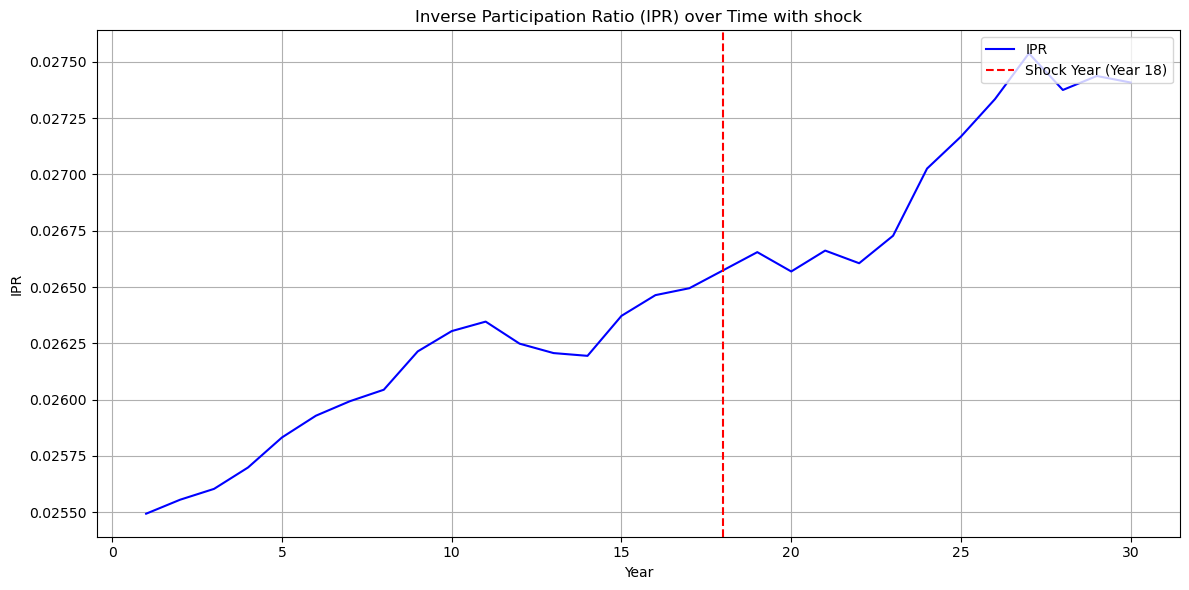

<Figure size 1200x600 with 0 Axes>

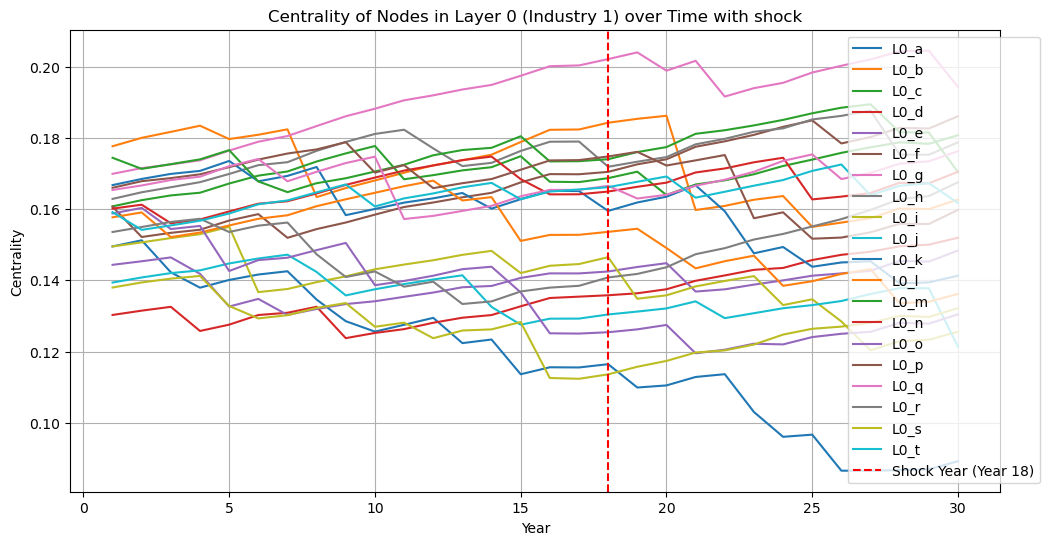

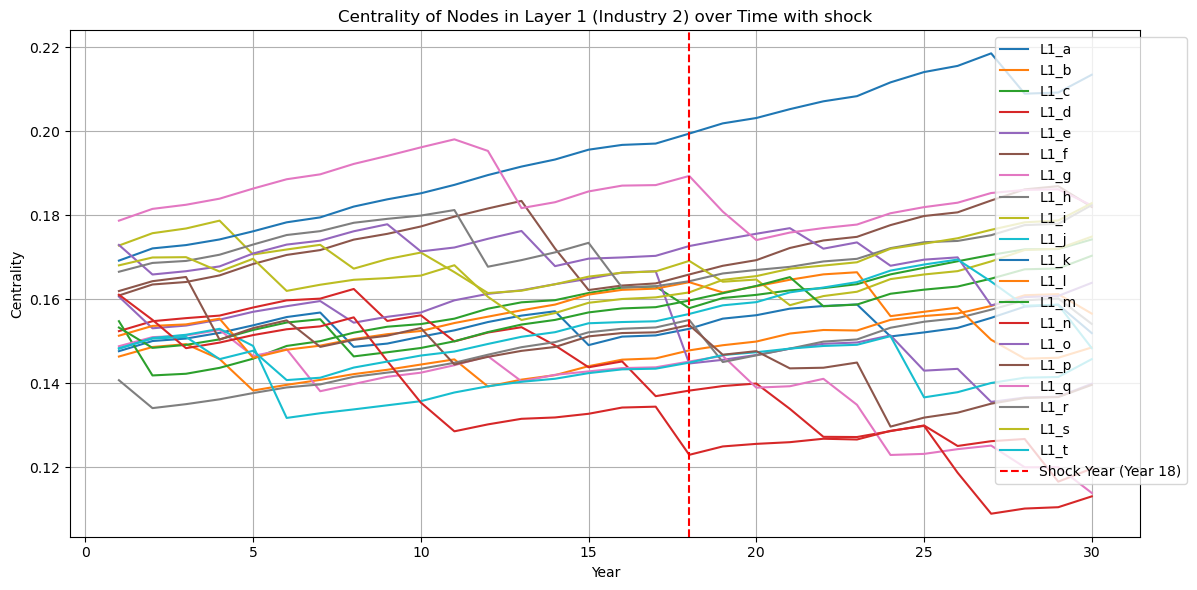

In [35]:
# Plot the IPR over time
plt.figure(figsize=(12, 6))

# Plot IPR over time
plt.plot(range(1, num_years + 1), ipr_values, label="IPR", color='blue')
plt.axvline(x=18, color='r', linestyle='--', label="Shock Year (Year 18)")
plt.title("Inverse Participation Ratio (IPR) over Time with shock")
plt.xlabel("Year")
plt.ylabel("IPR")
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot centrality evolution for two layers (Industry 1 and Industry 2)
plt.figure(figsize=(12, 6))

# Layer 0 (Industry 1) Centrality over time
layer0_nodes = [node for node in G.nodes() if G.nodes[node]['layer'] == 0]
layer0_centralities = {node: centrality_data[node] for node in layer0_nodes}

# Plot centrality for Layer 0 (Industry 1)
#plt.subplot(121)
plt.figure(figsize=(12, 6))
for node in layer0_nodes:
    plt.plot(range(1, num_years + 1), centrality_data[node], label=node)
plt.axvline(x=18, color='r', linestyle='--', label="Shock Year (Year 18)")
plt.title("Centrality of Nodes in Layer 0 (Industry 1) over Time with shock")
plt.xlabel("Year")
plt.ylabel("Centrality")
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), ncol=1)
plt.grid(True)

# Layer 1 (Industry 2) Centrality over time
layer1_nodes = [node for node in G.nodes() if G.nodes[node]['layer'] == 1]
layer1_centralities = {node: centrality_data[node] for node in layer1_nodes}

# Plot centrality for Layer 1 (Industry 2)
#plt.subplot(122)
plt.figure(figsize=(12, 6))
for node in layer1_nodes:
    plt.plot(range(1, num_years + 1), centrality_data[node], label=node)
plt.axvline(x=18, color='r', linestyle='--', label="Shock Year (Year 18)")
plt.title("Centrality of Nodes in Layer 1 (Industry 2) over Time with shock")
plt.xlabel("Year")
plt.ylabel("Centrality")
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), ncol=1)
plt.grid(True)

plt.tight_layout()
plt.show()